# Planaria

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.patches as patches
import sklearn.metrics.pairwise as knl
import networkx as nx
import copy

In [52]:
from sklearn.manifold import TSNE
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import sem
from matplotlib.ticker import FuncFormatter, MultipleLocator, ScalarFormatter
from tqdm import tqdm

from sklearn.neighbors import kneighbors_graph
from itertools import combinations

### Functions

In [10]:
def reverse_dict(dic):
    for r in dic.keys():
        if not isinstance(dic[r], list):
            dic[r] = [dic[r]]
    inverse = {v: k for k, l in dic.items() for v in l}
    return inverse

In [16]:
def flatten_list(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

In [ ]:
def shortest_paths(dist, nneigh=5, nsamples=5):
    """ 
    Compute shortest paths of kNN graph and MST
    """

    print('Getting kNN graph')
    W = kneighbors_graph(dist, nneigh, mode='distance',
                         include_self=False, metric='precomputed')
    G = nx.from_scipy_sparse_array(
        W, parallel_edges=False, create_using=None, edge_attribute='weight')
    print('Getting MST')
    T = nx.minimum_spanning_tree(G)

    random_samples = np.random.choice(list(G.nodes), nsamples, replace=False)
    random_samples = list(combinations(random_samples, 2))

    print('Getting shortest paths of kNN graph')
    # G_pls = np.array([nx.shortest_path_length(G, source=sn1[i], target=sn2[i], weight='weight') for i in tqdm(range(nsamples))])
    G_pls = np.array([nx.shortest_path_length(
        G, source=i, target=j, weight='weight') for i, j in tqdm(random_samples)])
    print('Getting shortest paths of MST')
    # T_pls = np.array([nx.shortest_path_length(T, source=sn1[i], target=sn2[i], weight='weight') for i in tqdm(range(nsamples))])
    T_pls = np.array([nx.shortest_path_length(
        T, source=i, target=j, weight='weight') for i, j in tqdm(random_samples)])
    return G_pls, T_pls

In [50]:
def form_class_graph(G, labels, quantile=0.9, threshold_by_class=False, just_class_metric=False):
    """ 
    Form a class graph from a graph G and labels    
    
    Parameters  
    ----------  
    G : graph
        A NetworkX graph object 
    labels : array
        An array of labels for each node in G   
    quantile : float
        The quantile to threshold the class graph by
    threshold_by_class : bool   
        Whether to threshold the class graph by class or not
    just_class_metric : bool    
        Whether to return just the class metric or not
    Returns 
    ------- 
    class_graph : graph 
        A NetworkX graph object of the class graph
    """

    # Create a defaultdict for class links
    class_links = {}

    # Add 'class' attribute to nodes
    for node in G.nodes:
        G.nodes[node]['class'] = labels[node]

    # Calculate class links and class sizes
    for edge in G.edges():
        if G.nodes[edge[0]]['class'] != G.nodes[edge[1]]['class']:
            class1, class2 = sorted(
                [G.nodes[edge[0]]['class'], G.nodes[edge[1]]['class']])
            class_links[(class1, class2)] = class_links.get(
                (class1, class2), 0) + 1

    class_sizes = pd.Series(labels).value_counts().to_dict()

    # Remove items with zero values in class_links
    class_links = {k: v for k, v in class_links.items() if v != 0}

    # Calculate total_class_links
    total_class_links = {}
    for v1, v2 in combinations(class_sizes.keys(), 2):
        total_class_links[(v1, v2)] = class_links.get(
            (v1, v2), 0) + class_links.get((v2, v1), 0)
    class_metric = {k: v for k, v in total_class_links.items() if v != 0}

    # Optionally finish early and return class_metric
    if just_class_metric:
        return class_metric

    if quantile != 0:
        if threshold_by_class:
            # Calculate class_links metric and filter by top % for each class
            class_thresholds = {}
            for class_label in set(labels):
                class_metrics_for_class = {k: v for k, v in class_metric.items(
                ) if k[0] == class_label or k[1] == class_label}

                quantile_threshold = np.quantile(
                    list(class_metrics_for_class.values()), quantile)
                class_thresholds[class_label] = quantile_threshold

            class_metrics_filtered = {k: v for k, v in class_metric.items(
            ) if v >= class_thresholds[k[0]] or v >= class_thresholds[k[1]]}
        else:
            # Calculate class_links metric and filter by top %
            quantile_threshold = np.quantile(
                list(class_metric.values()), quantile)
            class_metrics_filtered = {
                k: v for k, v in class_metric.items() if v >= quantile_threshold}
    else:
        class_metrics_filtered = class_metric

    # Create a DataFrame from class_links
    class_graph_df = pd.DataFrame(
        class_metrics_filtered.keys(), columns=['source', 'target'])
    class_graph_df['weight'] = class_metrics_filtered.values()

    # Create the celltype networkx graph
    class_graph = nx.from_pandas_edgelist(
        class_graph_df, source='source', target='target', edge_attr=True)
    return class_graph

In [60]:
# find value counts for items in labels
def find_value_counts(labels):
    value_counts = {}
    for label in labels:
        if label not in value_counts:
            value_counts[label] = 1
        else:
            value_counts[label] += 1
    return value_counts

## Introduction

Figure 1

In [2]:
## load data
zeta_file = 'data/zeta_5000.csv'
labels_file = 'data/sample_annotation_5000.txt'

zeta = np.loadtxt(zeta_file, delimiter=",")

# open labels and oredered_cats from csv
labels = np.genfromtxt(labels_file, delimiter=',', dtype=str)
ordered_cats = np.genfromtxt(
    'data/planaria_ordered_cats.csv', delimiter=',', dtype=str)

In [5]:
dim = 14
n, p = zeta.shape

## load colors
colors = pd.read_csv('data/colors_dataset.txt', header=None, sep='\t')
colors = {k: c for k, c in colors.values}

In [7]:
## TSNE
tsne = TSNE(n_components=2, perplexity = 30).fit_transform(zeta)

In [11]:
## relate category to overall class - for the plot legend 

class_to_cats = {'epidermal':
                 ['early epidermal progenitors',
                  'activated early epidermal progenitors', 'epidermal neoblasts',
                  'epidermis', 'epidermis DVb', 'epidermis DVb neoblast',
                  'late epidermal progenitors 1', 'late epidermal progenitors 2',
                  'pharynx cell type progenitors', 'pharynx cell type'],
                 'parenchymal':
                 ['glia', 'pgrn+ parenchymal cells',
                     'ldlrr-1+ parenchymal cells', 'psap+ parenchymal cells',
                     'aqp+ parenchymal cells', 'parenchymal progenitors',
                     'pigment'],
                 'gut':
                 ['phagocytes', 'goblet cells', 'psd+ cells', 'gut progenitors'],
                 'muscle':
                 ['muscle body', 'muscle pharynx', 'muscle progenitors'],
                 'neoblast':
                 ['neoblast 1', 'neoblast 2', 'neoblast 3', 'neoblast 4',
                     'neoblast 5', 'neoblast 6', 'neoblast 7', 'neoblast 8',
                     'neoblast 9', 'neoblast 10', 'neoblast 11', 'neoblast 12',
                     'neoblast 13'],
                 'neuronal':
                 ['ChAT neurons 1', 'ChAT neurons 2', 'GABA neurons',
                     'otf+ cells 1', 'otf+ cells 2', 'spp-11+ neurons',
                     'npp-18+ neurons', 'cav-1+ neurons', 'neural progenitors'],
                 'secretory':
                 ['secretory 1',
                     'secretory 2', 'secretory 3', 'secretory 4'],
                 'protonephridia':
                 ['protonephridia']}

class_to_cats = {key: class_to_cats[key] for key in sorted(class_to_cats)}

cats_to_class = reverse_dict(class_to_cats)

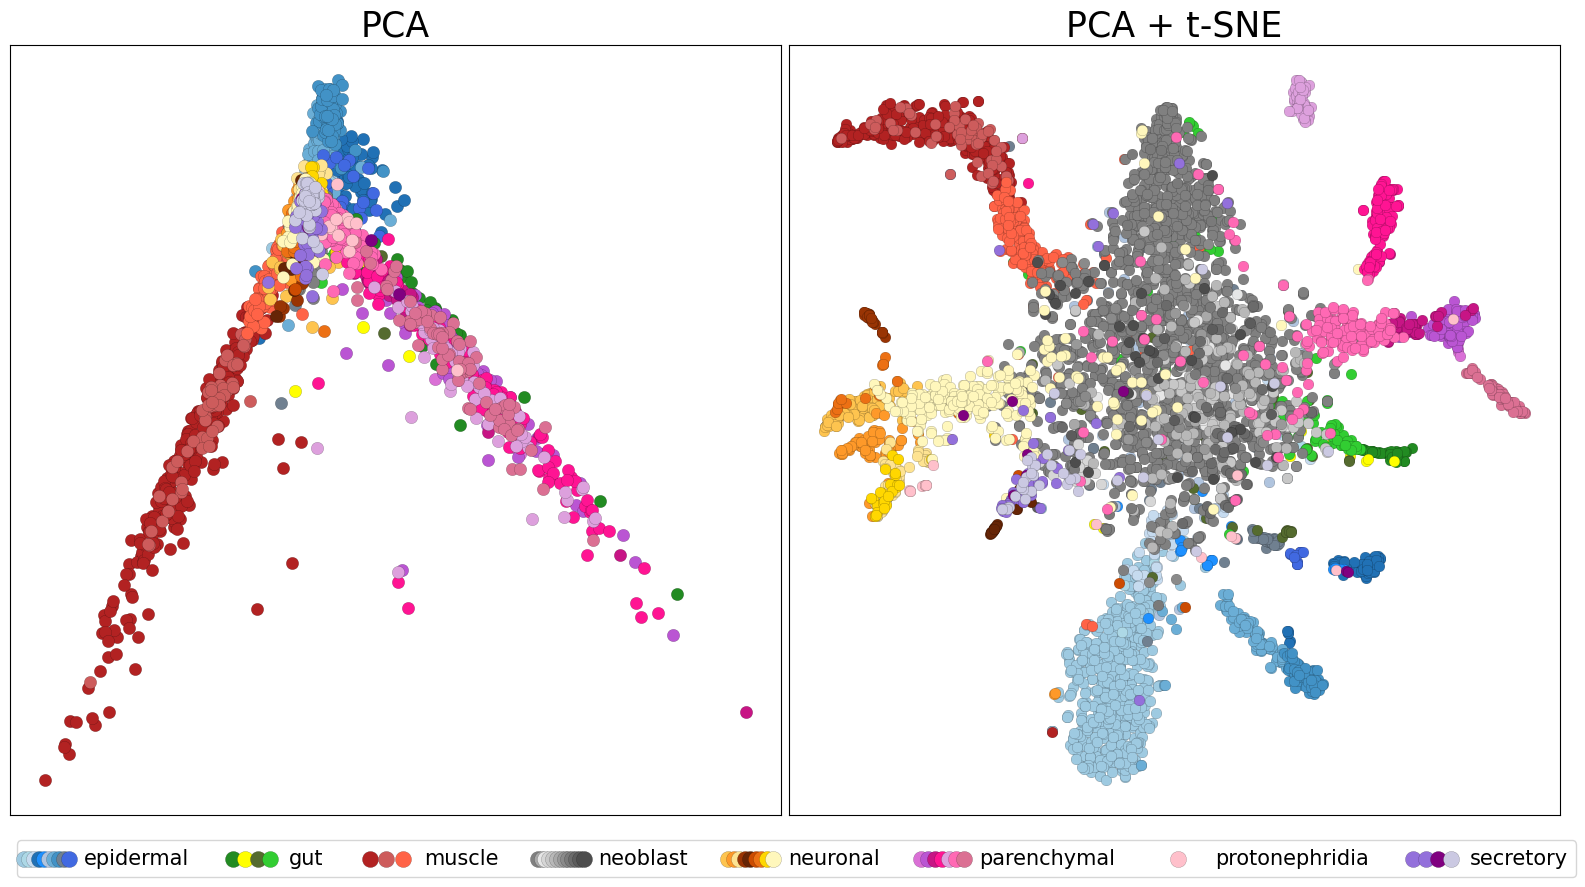

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plots = {}
plot_to_class = {}
i = 0
for t in flatten_list(list(class_to_cats.values())):
    idx = np.where(labels == t)[0]
    ax[0].scatter(zeta[idx, 0], zeta[idx, 1], marker='o', edgecolor='black',
                  linewidth=0.1, s=80, label=cats_to_class[t], c=colors[t])
    plots[i] = ax[1].scatter(tsne[idx, 0], tsne[idx, 1], marker='o', edgecolor='black',
                             linewidth=0.1, s=60, label=cats_to_class[t], alpha=1, c=colors[t])
    plot_to_class[i] = cats_to_class[t]
    i += 1

ax[0].set_title(f'PCA', fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[1].set_title(f'PCA + t-SNE', fontsize=25)

ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

_, labels1 = ax[1].get_legend_handles_labels()
labels1 = list(np.unique(np.array(labels1)))

class_to_plot = {value: [key for key, val in plot_to_class.items(
) if val == value] for value in plot_to_class.values()}

handles = [tuple([plots[i] for i in class_to_plot[cl]])
           for cl in list(class_to_cats.keys())]

ax[1].legend(handles=handles, labels=labels1, loc='upper center', bbox_to_anchor=(0.01, -0.02), ncol=8, markerscale=1.5, fontsize=15,
             handler_map={tuple: HandlerTuple(None)}, handlelength=2.0, handletextpad=0.8)

plt.subplots_adjust(wspace=0.01, hspace=0)

# fig.savefig(f"plots/planaria.png", bbox_inches='tight')

## Structure of PCA embedding

Figure 11 

In [40]:
## for figure 11a 

# make zeta's have magnitude 1
zeta_norm = zeta/np.linalg.norm(zeta, axis=1)[:, None]
n = zeta.shape[0]

zeta_inner_products = zeta_norm @ zeta_norm.T
# get upper triangle of zeta_inner_products
upper_triangle = np.triu_indices(n, 1)
zeta_inner_products_upper = zeta_inner_products[upper_triangle]

In [41]:
## for figure 11a 

d = dim
mean = np.zeros(d)  # Mean vector with zeros in all dimensions
cov = np.identity(d)  # Identity covariance matrix

points = np.random.multivariate_normal(mean, cov, n)

# Normalize the points to have unit length
norms = np.linalg.norm(points, axis=1)
normalized_points = points / norms[:, np.newaxis]

random_inner_products = normalized_points @ normalized_points.T
# get upper triangle of zeta_inner_products
upper_triangle = np.triu_indices(n, 1)
random_inner_products_upper = random_inner_products[upper_triangle]

In [29]:
ks = [5, 10, 25, 50]
nsims = list(range(10))
random_files = [list(zip([f'random_{k}nn_G_{n}.csv' for n in nsims], [f'random_{k}nn_T_{n}.csv' for n in nsims])) for k in ks]
planaria_files = [list((f'{k}nn_G.csv', f'{k}nn_T.csv')) for k in ks]

In [36]:
## for figure 11b
random_percentage_increase_df = pd.DataFrame(columns=list(range(len(ks))))
for k in tqdm(range(len(ks))):
    files = random_files[k]
    df_Gs = [pd.read_csv(os.path.join(
        'data/shortest_path_lengths', random_files[k][n][0]), header=None) for n in nsims]
    df_Ts = [pd.read_csv(os.path.join(
        'data/shortest_path_lengths', random_files[k][n][1]), header=None) for n in nsims]
    increase = [np.mean(np.array((df_Ts[i] - df_Gs[i]) / df_Gs[i]))
                for i in nsims]
    random_percentage_increase_df[k] = increase

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [04:22<00:00, 65.57s/it]


In [37]:
## for figure 11b
percentage_increases = []
for k in tqdm(range(len(planaria_files))):
    files = planaria_files[k]
    df_Gs = pd.read_csv(os.path.join(
        'data/shortest_path_lengths', files[0]), header=None)
    df_Ts = pd.read_csv(os.path.join(
        'data/shortest_path_lengths', files[1]), header=None)
    increase = np.mean(np.array((df_Ts - df_Gs) / df_Gs))
    percentage_increases.append(increase)

100%|██████████| 4/4 [00:25<00:00,  6.35s/it]


In [38]:
# for figure 11c

samples = np.random.choice(range(n), 5000, replace=False)
G_pls = np.array(pd.read_csv(os.path.join(
    'data/shortest_path_lengths', '10nn_G.csv'), header=None).iloc[samples]).flatten()
T_pls = np.array(pd.read_csv(os.path.join(
    'data/shortest_path_lengths', '10nn_T.csv'), header=None).iloc[samples]).flatten()

random_G_pls = np.array(pd.read_csv(os.path.join(
    'data/shortest_path_lengths', 'random_10nn_G_0.csv'), header=None).iloc[samples]).flatten()
random_T_pls = np.array(pd.read_csv(os.path.join(
    'data/shortest_path_lengths', 'random_10nn_T_0.csv'), header=None).iloc[samples]).flatten()

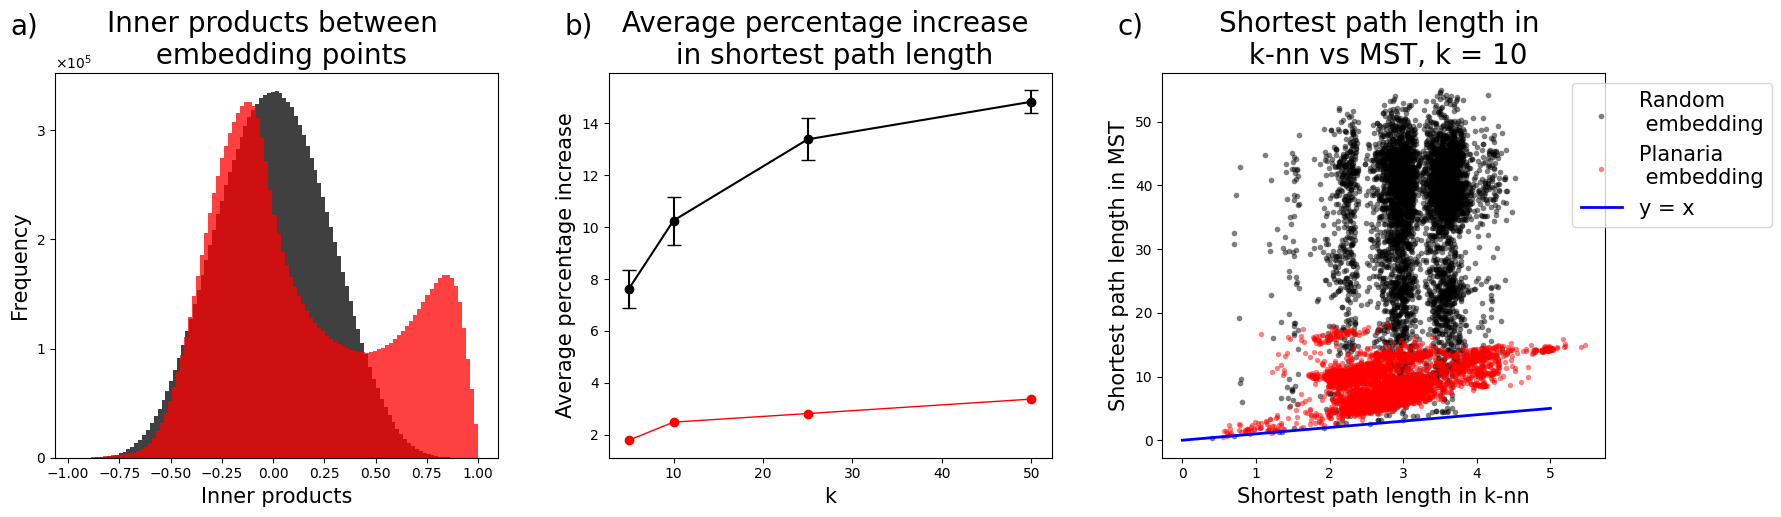

In [42]:

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
title_size = 20
axis_size = 15

ax[1].plot(ks, percentage_increase_df.mean(axis=0), marker='o',
           color='red', linewidth=1, label='Planaria')
ax[1].errorbar(ks, random_percentage_increase_df.mean(axis=0), yerr=[2*sem(random_percentage_increase_df[i])
               for i in random_percentage_increase_df.columns], fmt='-o', capsize=5, color='black', label='Random')
# ax[0].plot(ks, random_percentage_increase_means, marker = 'o',color='black', linewidth=1, label = 'Random');
ax[1].set_title(
    f'Average percentage increase \n in shortest path length', fontsize=title_size)
ax[1].set_xlabel('k', fontsize=axis_size)
ax[1].set_ylabel('Average percentage increase', fontsize=axis_size)

straight_line = np.ceil(np.min([np.max(G_pls), np.max(
    T_pls), np.max(random_G_pls), np.max(random_T_pls)]))
ax[2].scatter(random_G_pls, random_T_pls, marker='o', alpha=0.5,
              color='black', linewidth=0.1, s=15, label='Random \n embedding')
ax[2].scatter(G_pls, T_pls, marker='o', color='red', alpha=0.5,
              edgecolor='black', linewidth=0., s=15, label='Planaria \n embedding')
ax[2].plot([0, straight_line], [0, straight_line],
           c='blue', linewidth=2, label='y = x')
ax[2].set_title(
    f'Shortest path length in \n k-nn vs MST, k = 10', fontsize=title_size)
ax[2].set_xlabel('Shortest path length in k-nn', fontsize=axis_size)
ax[2].set_ylabel('Shortest path length in MST', fontsize=axis_size)

ax[2].legend(loc='upper right', bbox_to_anchor=(1.4, 1.0),
             fancybox=True, shadow=False, ncol=1, fontsize=axis_size)
ax[2].set_axisbelow(True)

# plots a histogram of random_inner_products_upper

ax[0].hist(random_inner_products_upper, bins=100,
           color='black', alpha=0.75, label='Random')
ax[0].hist(zeta_inner_products_upper, bins=100,
           color='red', alpha=0.75, label='Planaria')
ax[0].set_title(f'Inner products between \n embedding points',
                fontsize=title_size)
ax[0].set_xlabel('Inner products', fontsize=axis_size)
ax[0].set_ylabel('Frequency', fontsize=axis_size)

ax[0].yaxis.set_major_locator(MultipleLocator(base=1e5))

# Format the right axis label as "10^5"
right_label = ScalarFormatter(useMathText=True)
right_label.set_powerlimits((0, 0))
ax[0].yaxis.set_major_formatter(right_label)

# Add 'a)', 'b)', and 'c)' as text annotations
ax[0].annotate('a)', xy=(-0.1, 1.1),
               xycoords='axes fraction', fontsize=title_size)
ax[1].annotate('b)', xy=(-0.1, 1.1),
               xycoords='axes fraction', fontsize=title_size)
ax[2].annotate('c)', xy=(-0.1, 1.1),
               xycoords='axes fraction', fontsize=title_size)

plt.subplots_adjust(wspace=0.25)

# fig.savefig(f"plots/planaria_knn_vs_mst.png", bbox_inches='tight')

## Minimum spanning tree

Figure 12

In [46]:
zeta_inner_prods = 1/p * zeta @ zeta.T
zeta_cos_sim = knl.cosine_similarity(zeta)

# correct numerical value to be in correct domain of arccos
zeta_cos_sim = np.maximum(zeta_cos_sim, -1)
zeta_cos_sim = np.minimum(zeta_cos_sim, 1)
zeta_arc_dist = np.arccos(zeta_cos_sim)

In [49]:
nneigh = 10
W = kneighbors_graph(zeta_arc_dist, nneigh, mode='distance',
                     include_self=False, metric='precomputed')
G = nx.from_scipy_sparse_array(
    W, parallel_edges=False, create_using=None, edge_attribute='weight')

G_colors = [colors[labels[i]] for i in list(G.nodes)]

T = nx.minimum_spanning_tree(G)
positions = nx.nx_agraph.graphviz_layout(T, prog='sfdp')

In [54]:
class_graph = form_class_graph(
    T, labels, quantile=0.75, threshold_by_class=True, just_class_metric=False)

In [58]:
plot_graph = copy.deepcopy(class_graph)
# Identify nodes with 'neoblast' in their name
neoblast_nodes = [node for node in class_graph.nodes if 'neoblast ' in node]

# Create a new node to represent the combined 'neoblast' nodes
combined_neoblast_node = "neoblast"

# Add the combined node to the graph
plot_graph.add_node(combined_neoblast_node)

# Initialize a dictionary to store the combined weights for each neighbor
combined_weights = {}

# Iterate through the 'neoblast' nodes and their neighbors
for neoblast_node in neoblast_nodes:
    neighbors = list(class_graph.neighbors(neoblast_node))
    for neighbor in neighbors:
        if neighbor != combined_neoblast_node:
            # Get the weight of the edge and add it to the combined weight
            weight = class_graph[neoblast_node][neighbor].get(
                'weight', 1)  # Default weight to 1 if not specified
            combined_weights[neighbor] = combined_weights.get(
                neighbor, 0) + weight

# Add edges from the combined_neoblast_node to neighbors with combined weights
for neighbor, weight in combined_weights.items():
    plot_graph.add_edge(combined_neoblast_node, neighbor, weight=weight)


# Remove the original 'neoblast' nodes
plot_graph.remove_nodes_from(neoblast_nodes)

In [61]:
plot_colors = colors
plot_colors[combined_neoblast_node] = colors['neoblast 1']
# create dictionary of how often each ordered_cats appear in labels
ordered_cats_dict = find_value_counts(labels)
ordered_cats_dict['neoblast'] = np.sum(
    np.array([ordered_cats_dict[node] for node in neoblast_nodes]))
# ordered_cats_dict['neoblast'] = np.mean(np.array([ordered_cats_dict[node] for node in neoblast_nodes]))
node_sizes = [ordered_cats_dict[node] for node in plot_graph.nodes]

In [62]:
# find neoblast 1 neighbours in class graph
neoblast1_neighbours = [node for node in class_graph.neighbors('neoblast 1')]

In [63]:
# create subgraph of class_graph of all the neoblast nodes
neoblast_nodes = [node for node in class_graph.nodes if 'neoblast ' in node]
neoblast_subgraph = class_graph.subgraph(neoblast_nodes)
# neoblast_subgraph = nx.minimum_spanning_tree(neoblast_subgraph, weight='weight')
neoblast_subgraph = nx.Graph(neoblast_subgraph)

In [64]:
positions = nx.nx_agraph.graphviz_layout(T, prog="sfdp")
# Calculate the center of the positions
center_x = np.mean(list(positions.values()), axis=0)
center_x = np.array(center_x)

# Rotate the positions by 180 degrees around the center
positions = {node: 2 * center_x -
             np.array(pos) for node, pos in positions.items()}

# pos1 = centroids

centroids = {c: np.mean(np.array(list(positions.values()))[
                        np.where(labels == c)], axis=0) for c in ordered_cats}
centroids['neoblast'] = np.mean(
    np.array([centroids[n] for n in neoblast_nodes]), axis=0)
centroids['muscle pharynx'] = centroids['muscle pharynx'] + np.array([0, 50])
centroids['late epidermal progenitors 2'] = centroids['late epidermal progenitors 2'] + \
    np.array([-10, 20])
centroids['secretory 2'] = centroids['secretory 2'] + np.array([-20, -20])
centroids['GABA neurons'] = centroids['GABA neurons'] + np.array([-10, 20])
centroids['epidermis DVb neoblast'] = centroids['epidermis DVb neoblast'] + \
    np.array([-5, 60])
centroids['protonephridia'] = centroids['protonephridia'] + \
    np.array([-15, -15])
centroids['phagocytes'] = centroids['phagocytes'] + np.array([-20, 20])

In [65]:
neoblast_centroids = {node: centroids[node]
                      for node in neoblast_subgraph.nodes}

neoblast_centroids['neoblast 7'] = neoblast_centroids['neoblast 7'] + np.array([70, 0])

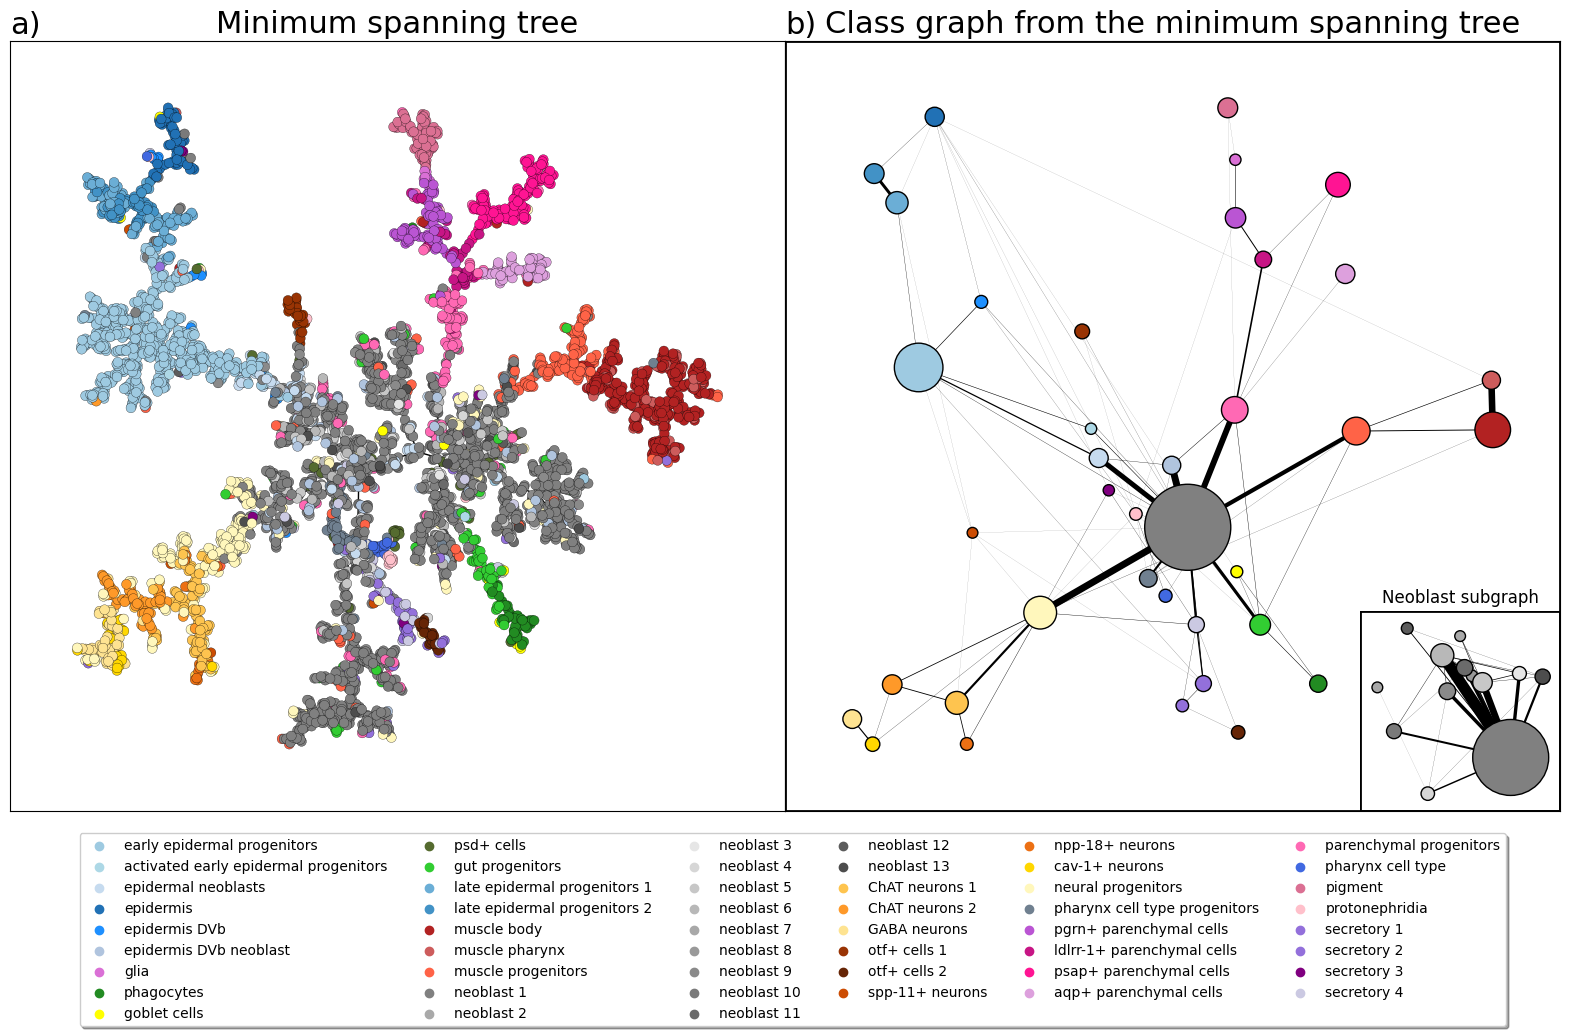

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first graph on the first subplot
# positions = nx.nx_agraph.graphviz_layout(T, prog="sfdp")
nodes1 = nx.draw_networkx_nodes(
    T, pos=positions, ax=axes[0], node_size=50, node_shape='o', alpha=1, node_color=G_colors)
nodes1.set_edgecolor('black')
nodes1.set_linewidth(0.2)
nx.draw_networkx_edges(
    T, pos=positions, ax=axes[0], alpha=1, edge_color='black', width=1)
axes[0].grid(False)
axes[0].set_title('Minimum spanning tree', fontsize=22)

# Plot the second graph on the second subplot
# pos1 = nx.nx_agraph.graphviz_layout(plot_graph, prog="sfdp", args='-Goverlap=false')
pos1 = centroids
ws = .0 + 5 * np.array(list(nx.get_edge_attributes(plot_graph, 'weight').values())) / np.max(
    np.array(list(nx.get_edge_attributes(plot_graph, 'weight').values())))
nx.draw(plot_graph, pos1, with_labels=False, node_size=50+2*np.array(node_sizes), node_color=[plot_colors[n] for n in plot_graph.nodes],
        font_size=6, font_color="black", font_weight="bold", width=ws, linewidths=1, edgecolors='black', ax=axes[1])

# Add a box around the second subplot
box = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black',
                        facecolor='none', transform=axes[1].transAxes)
axes[1].add_patch(box)
plt.subplots_adjust(wspace=0)

# make empty plot with correct color and label for each group
for node in ordered_cats:
    axes[1].scatter([], [], c=colors[node], label=node)


axes[1].legend(loc='upper center', bbox_to_anchor=(0.01, -0.02),
               fancybox=True, shadow=True, ncol=6)
axes[1].axes.xaxis.set_visible(False)
axes[1].axes.yaxis.set_visible(False)

axes[1].set_title('Class graph from the minimum spanning tree', fontsize=22)

axes[1].axis('on')
axes[1].grid(False)


# Add a small subplot within the bottom right-hand corner of the second subplot
subax = fig.add_axes([0.8, 0.11, 0.1, 0.2])  # [left, bottom, width, height]

ws = 8*np.array(list(nx.get_edge_attributes(neoblast_subgraph, 'weight').values())) / \
    np.max(np.array(list(nx.get_edge_attributes(
        neoblast_subgraph, 'weight').values())))
nx.draw(neoblast_subgraph, neoblast_centroids, with_labels=False,  node_color=[plot_colors[n] for n in neoblast_subgraph.nodes],
        node_size=50+2*np.array([ordered_cats_dict[node]
                                for node in neoblast_subgraph.nodes]),
        font_size=6, font_color="black", font_weight="bold", width=ws, linewidths=1, edgecolors='black', ax=subax)

box = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black',
                        facecolor='none', transform=subax.transAxes)
subax.add_patch(box)

subax.set_title('Neoblast subgraph')
subax.grid(False)
subax.axes.xaxis.set_visible(False)
subax.axes.yaxis.set_visible(False)
axes[0].annotate('a)', xy=(0, 1.01),
                 xycoords='axes fraction', fontsize=22)
axes[1].annotate('b)', xy=(0, 1.01),
                 xycoords='axes fraction', fontsize=22)

# Show the plot
# plt.show()
# fig.savefig('plots/MST_class_graph.png', bbox_inches='tight')
# Show the plot
plt.show()